In [1]:
# Import all libraries
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [2]:
# Define emotion labels based on your mapping
emotion_labels = {0: "Happy", 1: "Surprise", 2: "Sad", 3: "Anger", 4: "Disgust", 5: "Fear", 6: "Neutral"}

# Step 1: Load and Preprocess RAF-DB Dataset
class RAFDBDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        # RAF-DB classes: 1=Surprise, 2=Fear, 3=Disgust, 4=Happy, 5=Sad, 6=Anger, 7=Neutral
        # Desired mapping: Happy=0, Surprise=1, Sad=2, Anger=3, Disgust=4, Fear=5, Neutral=6
        self.label_map = {1: 1, 2: 5, 3: 4, 4: 0, 5: 2, 6: 3, 7: 6}
        
        # Dynamically load images and labels from folder structure
        self.image_data = []
        for class_folder in os.listdir(img_dir):
            class_path = os.path.join(img_dir, class_folder)
            if os.path.isdir(class_path) and class_folder.isdigit():
                label = int(class_folder)  # Get RAF-DB label (1-7) from folder name
                if label in self.label_map:
                    for filename in os.listdir(class_path):
                        if filename.endswith(".jpg") or filename.endswith(".png"):
                            self.image_data.append([filename, label])

        if not self.image_data:
            raise ValueError(f"No images found in {img_dir}")

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img_name, original_rafdb_label = self.image_data[idx]
        # Map RAF-DB label (1-7) to desired label (0-6)
        mapped_label = self.label_map[original_rafdb_label]
        # Construct image path using the original RAF-DB label (folder name)
        img_path = os.path.join(self.img_dir, str(original_rafdb_label), img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, mapped_label

# Define enhanced transforms for training with additional augmentations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.RandomHorizontalFlip(),                    # Horizontal flip
    transforms.RandomRotation(10),                        # Random rotation ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color adjustments
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),    # Random affine transformations
    transforms.Grayscale(num_output_channels=3),          # Convert to grayscale
    transforms.ToTensor(),                                # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize
])

# Define minimal transforms for testing
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),                          # Resize to 64x64
    transforms.Grayscale(num_output_channels=3),          # Convert to grayscale
    transforms.ToTensor(),                                # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize
])

# Load datasets with appropriate transforms
base_path = "/kaggle/input/raf-db-dataset"
train_img_dir = os.path.join(base_path, "DATASET/train")
test_img_dir = os.path.join(base_path, "DATASET/test")

# Check if dataset paths exist (optional, for debugging)
if not os.path.exists(train_img_dir):
    print(f"Warning: Training image directory not found at {train_img_dir}")
if not os.path.exists(test_img_dir):
    print(f"Warning: Test image directory not found at {test_img_dir}")

train_dataset = RAFDBDataset(
    img_dir=train_img_dir,
    transform=train_transforms  # Use augmented transforms for training
)
test_dataset = RAFDBDataset(
    img_dir=test_img_dir,
    transform=test_transforms   # Use minimal transforms for testing
)

# Print the number of images in train and test sets
print(f"Number of images in the train set: {len(train_dataset)}")
print(f"Number of images in the test set: {len(test_dataset)}")

# Check class distribution in the training set
train_original_labels = [item[1] for item in train_dataset.image_data]
train_class_counts = pd.Series(train_original_labels).value_counts().sort_index()
print("\nTraining set class distribution (Original RAF-DB labels 1-7 mapped to target emotion names):")
for original_label, count in train_class_counts.items():
    mapped_label_idx = train_dataset.label_map[original_label]
    emotion_name = emotion_labels[mapped_label_idx]
    print(f"Original Class {original_label} ({emotion_name}): {count} images")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=min(4, os.cpu_count()))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=min(4, os.cpu_count()))

# Print shapes of one batch from each loader
train_image, train_label = next(iter(train_loader))
print(f"\nTrain batch: Image shape {train_image.shape}, Label shape {train_label.shape}")

test_image, test_label = next(iter(test_loader))
print(f"Test batch: Image shape {test_image.shape}, Label shape {test_label.shape}")

Number of images in the train set: 12271
Number of images in the test set: 3068

Training set class distribution (Original RAF-DB labels 1-7 mapped to target emotion names):
Original Class 1 (Surprise): 1290 images
Original Class 2 (Fear): 281 images
Original Class 3 (Disgust): 717 images
Original Class 4 (Happy): 4772 images
Original Class 5 (Sad): 1982 images
Original Class 6 (Anger): 705 images
Original Class 7 (Neutral): 2524 images

Train batch: Image shape torch.Size([16, 3, 64, 64]), Label shape torch.Size([16])
Test batch: Image shape torch.Size([16, 3, 64, 64]), Label shape torch.Size([16])


Number of images processed in this batch: 16
Number of images displayed: 8


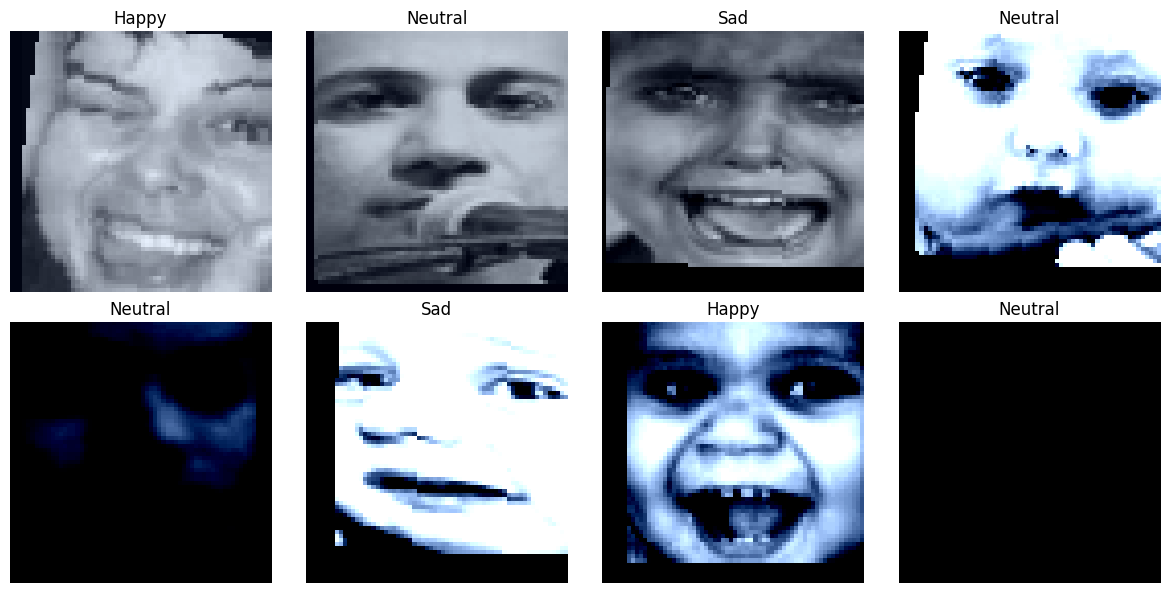

In [3]:
# After augmentation
# Function to denormalize images for visualization
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization: (tensor * std) + mean
    return tensor

# Get a batch of training images
images, labels = next(iter(train_loader))

# Denormalize images for visualization
images = denormalize(images)

# Print the number of images in the batch
print(f"Number of images processed in this batch: {images.shape[0]}")
print(f"Number of images displayed: 8")

# Plot the first 8 images in the batch
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    img = images[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    img = np.clip(img, 0, 1)  # Ensure pixel values are in [0, 1]
    axes[i].imshow(img)  # Since images are grayscale with 3 channels, this will show as grayscale
    axes[i].set_title(emotion_labels[labels[i].item()])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Step 1: Define Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Step 2: Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

# Step 3: Define ResEmoteNet with SE Blocks
class ResEmoteNet(nn.Module):
    def __init__(self, num_classes=7):
        super(ResEmoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.se = SEBlock(256)

        self.res_block1 = ResidualBlock(256, 512, stride=2)
        self.res_block2 = ResidualBlock(512, 1024, stride=2)
        self.res_block3 = ResidualBlock(1024, 2048, stride=2)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        x = self.se(x)

        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        x = self.pool(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

# Step 4: Initialize Device, Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResEmoteNet(num_classes=7).to(device)

# Step 5: Print total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")

# Step 6: Define loss and optimizer
criterion = nn.CrossEntropyLoss()
# SGD
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# AdamW
# optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Step 7: Checkpoint Management
checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

start_epoch = 0
best_acc = 0.0
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

train_losses, val_losses = [], []
train_accs, val_accs = [], []

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_acc = checkpoint['best_acc']
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_accs = checkpoint.get('train_accs', [])
    val_accs = checkpoint.get('val_accs', [])

    print(f"Resumed training from epoch {start_epoch} with best accuracy {best_acc:.2f}%")

80,238,599 total parameters.


In [ ]:
# Step 4: Train the Model
patience = 15
epochs_no_improve = 0
early_stop = False

num_epochs = 100
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # Use enumerate for batch count
    train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=True)
    for batch_idx, (images, labels) in train_progress:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1) # use .data to avoid graph issues if any, though not strictly necessary here
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Corrected postfix: average loss over batches processed so far
        train_progress.set_postfix({'loss': running_loss / (batch_idx + 1)})
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_running_loss = 0.0 # Use different variable name to avoid confusion
    val_correct = 0
    val_total = 0
    val_progress = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
    with torch.no_grad():
        for batch_idx, (images, labels) in val_progress:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_progress.set_postfix({'loss': val_running_loss / (batch_idx + 1)})
            
    val_loss = val_running_loss / len(test_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_acc': best_acc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }
    torch.save(checkpoint, checkpoint_path)

    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0  # Reset counter if improvement
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
        print(f"Saved best model with Val Acc: {best_acc:.2f}%")
    else:
        epochs_no_improve += 1
        print(f"No improvement in Val Acc for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            early_stop = True
            break

Epoch 1/100 [Training]: 100%|██████████| 767/767 [00:54<00:00, 13.99it/s, loss=1.65]


Epoch [1/100], Train Loss: 1.6543, Train Acc: 38.21%, Val Loss: 1.5453, Val Acc: 40.16%
Saved best model with Val Acc: 40.16%


Epoch 2/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.44it/s, loss=1.57]


Epoch [2/100], Train Loss: 1.5689, Train Acc: 41.44%, Val Loss: 1.3652, Val Acc: 50.03%
Saved best model with Val Acc: 50.03%


Epoch 3/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.29it/s, loss=1.51]


Epoch [3/100], Train Loss: 1.5117, Train Acc: 44.01%, Val Loss: 1.3699, Val Acc: 50.33%
Saved best model with Val Acc: 50.33%


Epoch 4/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.19it/s, loss=1.46]


Epoch [4/100], Train Loss: 1.4563, Train Acc: 46.40%, Val Loss: 1.2711, Val Acc: 51.73%
Saved best model with Val Acc: 51.73%


Epoch 5/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.22it/s, loss=1.41]


Epoch [5/100], Train Loss: 1.4141, Train Acc: 48.41%, Val Loss: 1.2445, Val Acc: 55.93%
Saved best model with Val Acc: 55.93%


Epoch 6/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.20it/s, loss=1.38]


Epoch [6/100], Train Loss: 1.3754, Train Acc: 49.88%, Val Loss: 1.1906, Val Acc: 57.63%
Saved best model with Val Acc: 57.63%


Epoch 7/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.21it/s, loss=1.35]


Epoch [7/100], Train Loss: 1.3525, Train Acc: 51.26%, Val Loss: 1.2061, Val Acc: 58.21%
Saved best model with Val Acc: 58.21%


Epoch 8/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.20it/s, loss=1.31]


Epoch [8/100], Train Loss: 1.3143, Train Acc: 52.82%, Val Loss: 1.3100, Val Acc: 53.23%
No improvement in Val Acc for 1 epochs.


Epoch 9/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.21it/s, loss=1.29]


Epoch [9/100], Train Loss: 1.2883, Train Acc: 54.53%, Val Loss: 1.2307, Val Acc: 56.71%
No improvement in Val Acc for 2 epochs.


Epoch 10/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.19it/s, loss=1.27]


Epoch [10/100], Train Loss: 1.2673, Train Acc: 55.40%, Val Loss: 1.0618, Val Acc: 62.65%
Saved best model with Val Acc: 62.65%


Epoch 11/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.21it/s, loss=1.23]


Epoch [11/100], Train Loss: 1.2311, Train Acc: 56.03%, Val Loss: 1.0302, Val Acc: 64.05%
Saved best model with Val Acc: 64.05%


Epoch 12/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.21it/s, loss=1.22]


Epoch [12/100], Train Loss: 1.2157, Train Acc: 57.16%, Val Loss: 1.0419, Val Acc: 65.12%
Saved best model with Val Acc: 65.12%


Epoch 13/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.22it/s, loss=1.18]


Epoch [13/100], Train Loss: 1.1847, Train Acc: 59.16%, Val Loss: 1.0720, Val Acc: 64.11%
No improvement in Val Acc for 1 epochs.


Epoch 14/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.26it/s, loss=1.18]


Epoch [14/100], Train Loss: 1.1775, Train Acc: 59.39%, Val Loss: 0.9628, Val Acc: 67.57%
Saved best model with Val Acc: 67.57%


Epoch 15/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.23it/s, loss=1.15]


Epoch [15/100], Train Loss: 1.1537, Train Acc: 60.07%, Val Loss: 0.9926, Val Acc: 66.36%
No improvement in Val Acc for 1 epochs.


Epoch 16/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.23it/s, loss=1.12]


Epoch [16/100], Train Loss: 1.1203, Train Acc: 61.40%, Val Loss: 0.9350, Val Acc: 68.29%
Saved best model with Val Acc: 68.29%


Epoch 17/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.20it/s, loss=1.11]


Epoch [17/100], Train Loss: 1.1110, Train Acc: 61.50%, Val Loss: 0.9097, Val Acc: 68.74%
Saved best model with Val Acc: 68.74%


Epoch 18/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.22it/s, loss=1.09]


Epoch [18/100], Train Loss: 1.0880, Train Acc: 62.39%, Val Loss: 0.9000, Val Acc: 69.78%
Saved best model with Val Acc: 69.78%


Epoch 19/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.22it/s, loss=1.07]


Epoch [19/100], Train Loss: 1.0669, Train Acc: 63.03%, Val Loss: 0.8653, Val Acc: 69.36%
No improvement in Val Acc for 1 epochs.


Epoch 20/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.24it/s, loss=1.05]


Epoch [20/100], Train Loss: 1.0536, Train Acc: 63.77%, Val Loss: 0.8855, Val Acc: 69.69%
No improvement in Val Acc for 2 epochs.


Epoch 21/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.21it/s, loss=1.04]


Epoch [21/100], Train Loss: 1.0427, Train Acc: 63.51%, Val Loss: 0.8508, Val Acc: 72.36%
Saved best model with Val Acc: 72.36%


Epoch 22/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.22it/s, loss=1.02] 


Epoch [22/100], Train Loss: 1.0182, Train Acc: 64.95%, Val Loss: 0.8279, Val Acc: 71.25%
No improvement in Val Acc for 1 epochs.


Epoch 23/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.21it/s, loss=1.01]


Epoch [23/100], Train Loss: 1.0091, Train Acc: 65.60%, Val Loss: 0.8166, Val Acc: 71.97%
No improvement in Val Acc for 2 epochs.


Epoch 24/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.20it/s, loss=0.979]


Epoch [24/100], Train Loss: 0.9786, Train Acc: 66.38%, Val Loss: 0.8343, Val Acc: 71.51%
No improvement in Val Acc for 3 epochs.


Epoch 25/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.22it/s, loss=0.981]


Epoch [25/100], Train Loss: 0.9806, Train Acc: 66.27%, Val Loss: 0.8089, Val Acc: 73.60%
Saved best model with Val Acc: 73.60%


Epoch 26/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.21it/s, loss=0.959]


Epoch [26/100], Train Loss: 0.9593, Train Acc: 66.91%, Val Loss: 0.8401, Val Acc: 72.26%
No improvement in Val Acc for 1 epochs.


Epoch 27/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.25it/s, loss=0.941]


Epoch [27/100], Train Loss: 0.9413, Train Acc: 67.51%, Val Loss: 0.7584, Val Acc: 74.02%
Saved best model with Val Acc: 74.02%


Epoch 28/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.22it/s, loss=0.944]


Epoch [28/100], Train Loss: 0.9437, Train Acc: 67.47%, Val Loss: 0.7908, Val Acc: 73.04%
No improvement in Val Acc for 1 epochs.


Epoch 29/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.28it/s, loss=0.923]


Epoch [29/100], Train Loss: 0.9233, Train Acc: 68.26%, Val Loss: 0.7149, Val Acc: 75.95%
Saved best model with Val Acc: 75.95%


Epoch 30/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.22it/s, loss=0.918]


Epoch [30/100], Train Loss: 0.9179, Train Acc: 68.83%, Val Loss: 0.7719, Val Acc: 74.35%
No improvement in Val Acc for 1 epochs.


Epoch 31/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.28it/s, loss=0.909]


Epoch [31/100], Train Loss: 0.9093, Train Acc: 68.95%, Val Loss: 0.7814, Val Acc: 71.81%
No improvement in Val Acc for 2 epochs.


Epoch 32/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.21it/s, loss=0.896]


Epoch [32/100], Train Loss: 0.8955, Train Acc: 69.16%, Val Loss: 0.7162, Val Acc: 75.33%
No improvement in Val Acc for 3 epochs.


Epoch 33/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.27it/s, loss=0.883]


Epoch [33/100], Train Loss: 0.8829, Train Acc: 69.87%, Val Loss: 0.7062, Val Acc: 75.62%
No improvement in Val Acc for 4 epochs.


Epoch 34/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.22it/s, loss=0.876]


Epoch [34/100], Train Loss: 0.8758, Train Acc: 70.22%, Val Loss: 0.7128, Val Acc: 75.65%
No improvement in Val Acc for 5 epochs.


Epoch 35/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.26it/s, loss=0.871]


Epoch [35/100], Train Loss: 0.8713, Train Acc: 69.82%, Val Loss: 0.7671, Val Acc: 73.60%
No improvement in Val Acc for 6 epochs.


Epoch 36/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.21it/s, loss=0.871]


Epoch [36/100], Train Loss: 0.8707, Train Acc: 70.17%, Val Loss: 0.7032, Val Acc: 75.85%
No improvement in Val Acc for 7 epochs.


Epoch 37/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.24it/s, loss=0.857]


Epoch [37/100], Train Loss: 0.8565, Train Acc: 70.78%, Val Loss: 0.7255, Val Acc: 75.23%
No improvement in Val Acc for 8 epochs.


Epoch 38/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.21it/s, loss=0.84] 


Epoch [38/100], Train Loss: 0.8401, Train Acc: 71.10%, Val Loss: 0.6873, Val Acc: 75.88%
No improvement in Val Acc for 9 epochs.


Epoch 39/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.19it/s, loss=0.828]


Epoch [39/100], Train Loss: 0.8282, Train Acc: 71.54%, Val Loss: 0.7119, Val Acc: 74.54%
No improvement in Val Acc for 10 epochs.


Epoch 40/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.20it/s, loss=0.842]


Epoch [40/100], Train Loss: 0.8422, Train Acc: 71.35%, Val Loss: 0.6739, Val Acc: 77.57%
Saved best model with Val Acc: 77.57%


Epoch 41/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.21it/s, loss=0.82] 


Epoch [41/100], Train Loss: 0.8197, Train Acc: 71.98%, Val Loss: 0.6533, Val Acc: 78.42%
Saved best model with Val Acc: 78.42%


Epoch 42/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.19it/s, loss=0.823]


Epoch [42/100], Train Loss: 0.8226, Train Acc: 71.90%, Val Loss: 0.7260, Val Acc: 74.15%
No improvement in Val Acc for 1 epochs.


Epoch 43/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.24it/s, loss=0.808]


Epoch [43/100], Train Loss: 0.8084, Train Acc: 72.38%, Val Loss: 0.6469, Val Acc: 78.03%
No improvement in Val Acc for 2 epochs.


Epoch 44/100 [Training]: 100%|██████████| 767/767 [00:58<00:00, 13.20it/s, loss=0.807]


Epoch [44/100], Train Loss: 0.8074, Train Acc: 72.35%, Val Loss: 0.6735, Val Acc: 77.25%
No improvement in Val Acc for 3 epochs.


Epoch 45/100 [Training]: 100%|██████████| 767/767 [00:57<00:00, 13.26it/s, loss=0.799]


Epoch [45/100], Train Loss: 0.7992, Train Acc: 72.94%, Val Loss: 0.6382, Val Acc: 77.80%
No improvement in Val Acc for 4 epochs.


Epoch 46/100 [Training]:  92%|█████████▏| 707/767 [00:53<00:04, 13.24it/s, loss=0.798]

In [ ]:
# Step 5: Save Final Model
torch.save(model.state_dict(), "/kaggle/working/final_model.pth")
print("Saved final model state to /kaggle/working/final_model.pth")

In [ ]:
# Step 6: Evaluate Model
# Load the best model for evaluation
if os.path.exists("/kaggle/working/best_model.pth"):
    model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))
    print("Loaded best model for evaluation.")
else:
    print("Best model not found. Evaluating with the final model.")
    # If best_model.pth doesn't exist (e.g. training for 0 epochs or never improved), 
    # model already has final weights. Or load final_model.pth if script was restarted.
    if os.path.exists("/kaggle/working/final_model.pth"):
         model.load_state_dict(torch.load("/kaggle/working/final_model.pth", map_location=device))
    else:
        print("No saved model found for evaluation.")


model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

if total > 0:
    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
else:
    print("Test set is empty or not loaded correctly. Cannot compute accuracy.")
    test_acc = 0.0 # Default value

In [ ]:
# Step 7: Plot Training Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("/kaggle/working/training_curves.png")
plt.show()
print("Saved training curves to /kaggle/working/training_curves.png")

In [ ]:
# Step 8: Confusion Matrix with Emotion Labels
if all_labels and all_preds: # Ensure lists are not empty
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8)) # Increased size for better readability
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=[emotion_labels[i] for i in range(len(emotion_labels))], 
                yticklabels=[emotion_labels[i] for i in range(len(emotion_labels))])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig("/kaggle/working/confusion_matrix.png")
    plt.show()
    print("Saved confusion matrix to /kaggle/working/confusion_matrix.png")
else:
    print("No labels/predictions available for confusion matrix (e.g., test set was empty or evaluation skipped).")